In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re,string
import itertools 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings("ignore")

In [2]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [3]:
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')

In [4]:
df_train.head()

,Unnamed: 0,promptId,uniqueId,essay,evaluator_rating
0,0,1,1_323,"At present age, our education system is not go...",3.0
1,1,1,1_238,I am agree the tightly defined curriculum of o...,4.0
2,2,1,1_212,I strongly agree with the statement that tight...,2.0
3,3,1,1_117,Our education system is nice quitely but i dis...,2.0
4,4,1,1_229,i am totally agree with the statement that tig...,3.0


In [5]:
df_test.head()

,Unnamed: 0,promptId,uniqueId,essay
0,0,1,1_315,Curriculum has been adopted in many schools. T...
1,1,1,1_214,"I strongly agree with the statement , The tig..."
2,2,1,1_196,Imagination and creativity is the most importa...
3,3,1,1_178,In our eduction system leaves no room for imag...
4,4,1,1_201,"I will agree at some what extend, because if w..."


In [6]:
df_train.drop(["Unnamed: 0","uniqueId","promptId"],axis=1,inplace=True)
df_test.drop(["Unnamed: 0","uniqueId","promptId"],axis=1,inplace=True)

In [7]:
df_train.head()

,essay,evaluator_rating
0,"At present age, our education system is not go...",3.0
1,I am agree the tightly defined curriculum of o...,4.0
2,I strongly agree with the statement that tight...,2.0
3,Our education system is nice quitely but i dis...,2.0
4,i am totally agree with the statement that tig...,3.0


In [8]:
print(df_train.shape)
print(df_test.shape)

(1240, 2)
(305, 1)


In [9]:
df_train.isna().sum()

essay               0
evaluator_rating    0
dtype: int64

### We can see there is no null values so its good to go ahead

In [10]:
df_test.isna().sum()

essay    0
dtype: int64

### We can see there is no null values in test also

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1240 entries, 0 to 1239
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   essay             1240 non-null   object 
 1   evaluator_rating  1240 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.5+ KB


In [12]:
df_train.describe()


,evaluator_rating
count,1240.000000
mean,2.684274
std,1.082603
min,0.000000
25%,2.000000
50%,3.000000
75%,3.500000
max,5.000000


#### As we can see max score is 5 and 75% student score is under 3.5 and 25% under 2

In [13]:
print(df_train['evaluator_rating'].max())
print(df_train['evaluator_rating'].min())

5.0
0.0


In [14]:
print(df_train.groupby('evaluator_rating').size())

evaluator_rating
0.0     96
0.5      6
1.0     30
1.5     53
2.0    130
2.5    223
3.0    283
3.5    288
4.0    101
4.5     25
5.0      5
dtype: int64


<AxesSubplot:ylabel='evaluator_rating'>

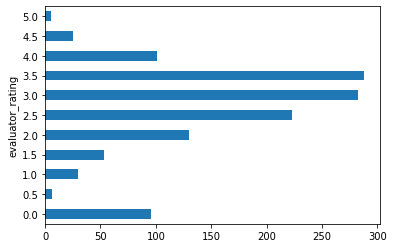

In [15]:
df_train.groupby('evaluator_rating').size().plot.barh()

### No of student scoring 3.5 is 288 and maximum marks is only obtained by 5 student

# Preprocessing

Almost every nlp task require to be preprocesses before training model. Here we are processing our data by replacing apostrrophes with standard meaning, lowering text removing stop words and finally lemmatization( I am doing this because in future If I do spell checker it will give benefit) 

In [16]:
stop_words = set(stopwords.words('english'))

def cleanData(text, lowercase = False, remove_stops = False, stemming = False, lemmatization = False):
    txt = str(text)
    # Replace apostrophes with standard lexicons
    txt = txt.replace("isn't", "is not")
    txt = txt.replace("aren't", "are not")
    txt = txt.replace("ain't", "am not")
    txt = txt.replace("won't", "will not")
    txt = txt.replace("didn't", "did not")
    txt = txt.replace("shan't", "shall not")
    txt = txt.replace("haven't", "have not")
    txt = txt.replace("hadn't", "had not")
    txt = txt.replace("hasn't", "has not")
    txt = txt.replace("don't", "do not")
    txt = txt.replace("wasn't", "was not")
    txt = txt.replace("weren't", "were not")
    txt = txt.replace("doesn't", "does not")
    txt = txt.replace("'s", " is")
    txt = txt.replace("'re", " are")
    txt = txt.replace("'m", " am")
    txt = txt.replace("'d", " would")
    txt = txt.replace("'ll", " will")

    # More cleaning
    txt = re.sub(r"alot", "a lot", txt)
    txt = re.sub(r"what's", "what", txt)
    txt = re.sub(r"What's", "what", txt)
    
    
    # Remove urls and emails
    txt = re.sub(r'^https?:\/\/.*[\r\n]*', ' ', txt, flags=re.MULTILINE)
    txt = re.sub(r'[\w\.-]+@[\w\.-]+', ' ', txt, flags=re.MULTILINE)
    
    # Remove punctuation from text
    txt = ''.join([c for c in text if c not in punctuation])
    
    # Remove all symbols
    txt = re.sub(r'[^A-Za-z\s]',r' ',txt)
    txt = re.sub(r'\n',r' ',txt)
    
    if lowercase:
        txt = " ".join([w.lower() for w in txt.split()])
        
    if remove_stops:
        txt = " ".join([w for w in txt.split() if w not in stop_words])
        
    if stemming:
        st = PorterStemmer()
        txt = " ".join([st.stem(w) for w in txt.split()])
    
    if lemmatization:
        wordnet_lemmatizer = WordNetLemmatizer()
        txt = " ".join([wordnet_lemmatizer.lemmatize(w, pos='v') for w in txt.split()])

    return txt

In [17]:
df_train['essay'] = df_train['essay'].apply(lambda x: cleanData(x, lowercase=True, remove_stops=True, stemming=False, lemmatization = True))

In [18]:
df_test['essay'] = df_test['essay'].apply(lambda x: cleanData(x, lowercase=True, remove_stops=True, stemming=False, lemmatization = True))

In [19]:
df_test['essay'].head()

0    curriculum adopt many school curriculum great ...
1    strongly agree statement tightly define curric...
2    imagination creativity important thing develop...
3    eduction system leave room imagination creativ...
4    agree extend think regular basic university mu...
Name: essay, dtype: object

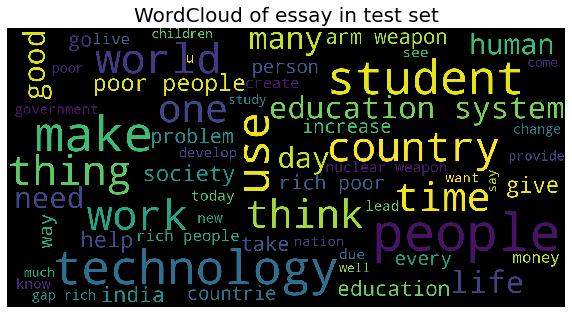

In [20]:
wc= WordCloud(width=1600,height=800, margin=0,max_words=500, 
max_font_size=150, min_font_size=30,).generate(" ".join(df_train['essay']))
plt.figure(figsize=(10, 16))
plt.imshow(wc, interpolation="nearest")
plt.title('WordCloud of essay in test set', fontsize = 20)
plt.axis("off")
plt.show()

## Model
Here we define a 1-Layer LSTM Model and Embedding.
Activation fuction used--> Relu

In [21]:
from tensorflow.keras.layers import Embedding,Dropout,Bidirectional,LSTM,Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot

In [22]:
#vocab size
voc_size=6000

In [23]:
onehot_repr_train=[one_hot(words,voc_size)for words in df_train['essay']] 
onehot_repr_test=[one_hot(words,voc_size)for words in df_test['essay']] 

One-Hot Encoding. Each words are going to take a particular index for eg. Let say a text="rishabh is a good boy. rishabh is 
hard working boy". so when we do one-hot it will transform as [[23, 24,5,45,42],[23, 24,34,23,42]]. Here 23 indicates "rishabh" and 24 indicates "is".
#### Note- This index value can be change if we give different vocab size.

In [24]:
res = df_train['essay'].str.split().str.len().max()
print("The maximum length in words are : " +  str(res)) 

The maximum length in words are : 284


In [25]:
#Padding given values so every sentence has same dimension
sent_length=285
oneHotDoc=pad_sequences(onehot_repr_train,padding='pre',maxlen=sent_length)
print(oneHotDoc)

[[   0    0    0 ... 2574 2440 4329]
 [   0    0    0 ... 3371 1830   27]
 [   0    0    0 ... 3682 1194 2165]
 ...
 [   0    0    0 ... 4903 5395 2194]
 [   0    0    0 ... 1243  858  888]
 [   0 1287  367 ... 1864 4575 3627]]


In [26]:
def myModel():
    embedding_vector_features=200
    model = Sequential()
    model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
    model.add(Bidirectional(LSTM(100, recurrent_dropout=0.4)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()
    return model

In [27]:
X_final=np.array(oneHotDoc)
y_final=np.array(df_train['evaluator_rating'])
X_final

array([[   0,    0,    0, ..., 2574, 2440, 4329],
       [   0,    0,    0, ..., 3371, 1830,   27],
       [   0,    0,    0, ..., 3682, 1194, 2165],
       ...,
       [   0,    0,    0, ..., 4903, 5395, 2194],
       [   0,    0,    0, ..., 1243,  858,  888],
       [   0, 1287,  367, ..., 1864, 4575, 3627]])

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [29]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(830, 285)
(830,)
(410, 285)
(410,)


In [30]:
lstm_model = myModel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 285, 200)          1200000   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               240800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 1,441,001
Trainable params: 1,441,001
Non-trainable params: 0
_________________________________________________________________


In [31]:
lstm_model.fit(X_train, y_train, batch_size=64, epochs=150)

Epoch 1/150
13/13 [==============================] - 40s 2s/step - loss: 2.4389 - mae: 1.2252
Epoch 2/150
13/13 [==============================] - 32s 2s/step - loss: 1.2432 - mae: 0.8593
Epoch 3/150
13/13 [==============================] - 34s 3s/step - loss: 1.1708 - mae: 0.8490
Epoch 4/150
13/13 [==============================] - 29s 2s/step - loss: 0.9981 - mae: 0.7839
Epoch 5/150
13/13 [==============================] - 27s 2s/step - loss: 0.5484 - mae: 0.5817
Epoch 6/150
13/13 [==============================] - 28s 2s/step - loss: 0.4432 - mae: 0.5265
Epoch 7/150
13/13 [==============================] - 24s 2s/step - loss: 0.3602 - mae: 0.4724
Epoch 8/150
13/13 [==============================] - 24s 2s/step - loss: 0.2954 - mae: 0.4229
Epoch 9/150
13/13 [==============================] - 26s 2s/step - loss: 0.3119 - mae: 0.4291
Epoch 10/150
13/13 [==============================] - 30s 2s/step - loss: 0.2627 - mae: 0.4024
Epoch 11/150
13/13 [==============================] - 25s 2

13/13 [==============================] - 23s 2s/step - loss: 0.0749 - mae: 0.2074
Epoch 88/150
13/13 [==============================] - 24s 2s/step - loss: 0.0647 - mae: 0.1911
Epoch 89/150
13/13 [==============================] - 24s 2s/step - loss: 0.0752 - mae: 0.2055
Epoch 90/150
13/13 [==============================] - 24s 2s/step - loss: 0.0791 - mae: 0.2106
Epoch 91/150
13/13 [==============================] - 23s 2s/step - loss: 0.0692 - mae: 0.1952
Epoch 92/150
13/13 [==============================] - 24s 2s/step - loss: 0.0731 - mae: 0.2037
Epoch 93/150
13/13 [==============================] - 23s 2s/step - loss: 0.0728 - mae: 0.2051
Epoch 94/150
13/13 [==============================] - 23s 2s/step - loss: 0.0707 - mae: 0.1977
Epoch 95/150
13/13 [==============================] - 23s 2s/step - loss: 0.0800 - mae: 0.2153
Epoch 96/150
13/13 [==============================] - 23s 2s/step - loss: 0.0782 - mae: 0.2120
Epoch 97/150
13/13 [==============================] - 23s 2s/st

In [32]:
y_pred = lstm_model.predict(X_test)

In [33]:
y_pred

array([[2.4786234 ],
       [3.4206767 ],
       [3.3486528 ],
       [3.099969  ],
       [3.3517966 ],
       [1.3969707 ],
       [2.3033404 ],
       [2.9177303 ],
       [3.1636238 ],
       [2.736199  ],
       [2.5316644 ],
       [2.55232   ],
       [2.4150863 ],
       [2.7612634 ],
       [3.2135344 ],
       [2.9920468 ],
       [3.2012544 ],
       [2.3485217 ],
       [2.3752704 ],
       [3.2514577 ],
       [2.6034446 ],
       [2.9975085 ],
       [2.453383  ],
       [2.511022  ],
       [2.7657595 ],
       [0.7655141 ],
       [2.5260549 ],
       [2.9710684 ],
       [2.7629113 ],
       [1.1854593 ],
       [2.568894  ],
       [2.598764  ],
       [3.627931  ],
       [2.5615969 ],
       [2.2806234 ],
       [3.1004186 ],
       [3.4501405 ],
       [1.9310635 ],
       [2.149951  ],
       [0.        ],
       [2.8213077 ],
       [3.460343  ],
       [2.5185885 ],
       [2.777463  ],
       [3.1809993 ],
       [2.7389226 ],
       [3.5423265 ],
       [3.269

In [34]:
from sklearn.metrics import mean_squared_error

In [35]:
mean_squared_error(y_pred,y_test)
#epoch =50 we get mse 1.3529 vocab_size is 2000
#epoch=70 we get mse 1.3514 vocab_size is 2000
#epoch =50 we get mse 1.4 vocab_size is 2000
#epoch =70 Bidirectional LSTM mse 1.19 voacb_size is 8000 Vector dimension is 200
#epoch =100 Bidirectional LSTM mse 1.17 voacb_size is 8000 Vector dimension is 200
#epoch =1500 Bidirectional LSTM mse 1.10 voacb_size is 8000 Vector dimension is 200

1.1072684273649354

In [36]:
sent_length=285
embedded_docs_test=pad_sequences(onehot_repr_test,padding='pre',maxlen=sent_length)

In [37]:
X_new=np.array(embedded_docs_test)

In [38]:
X_new

array([[   0,    0,    0, ..., 3342, 5728, 5739],
       [   0,    0,    0, ..., 4368, 3397,   21],
       [   0,    0,    0, ..., 5039, 2655, 3849],
       ...,
       [   0,    0,    0, ..., 1228, 2246,  176],
       [   0,    0,    0, ..., 5551, 5395, 4732],
       [   0,    0,    0, ..., 5551, 4736, 2417]])

In [39]:
y_pred_new = lstm_model.predict(X_new)

In [40]:
y_pred_new.shape

(305, 1)

In [95]:
yete=y_pred_new.flatten().round(1)
yete

array([2.3, 3.2, 2.5, 3.1, 3.5, 2.7, 3. , 2.4, 2.4, 3. , 3.4, 2.8, 2.2,
       3.1, 2.2, 2.6, 3.5, 3.3, 3.4, 2. , 2.7, 2.5, 2.5, 2.8, 2.1, 2.2,
       3.4, 2.6, 2.3, 2.8, 2.8, 2.9, 2.7, 3.1, 2.9, 3.3, 3.8, 3. , 3.3,
       2.7, 4. , 1.7, 3.7, 3. , 2.4, 2.7, 3.1, 3.1, 2.7, 3. , 2. , 2.6,
       3.4, 2.4, 3. , 2. , 2.7, 2.8, 3.1, 2.2, 3. , 1.5, 3.3, 3.5, 2.9,
       3. , 2.4, 1.5, 3.1, 2.4, 3. , 2.6, 2.9, 3.1, 2. , 2.1, 2.9, 2.9,
       1.8, 2.4, 3. , 3.4, 2.3, 3.1, 2.4, 2.8, 2.5, 2.1, 1.8, 1.8, 3.2,
       3.3, 3.5, 3.1, 2.9, 2. , 2.5, 2.8, 2.6, 2.1, 2.7, 2.6, 2.7, 2.7,
       1.8, 3.3, 2.9, 3.2, 1.7, 2.5, 3. , 2.4, 2.5, 1.7, 3.2, 2.6, 2.6,
       2.1, 3.3, 2.9, 1.5, 2.6, 2.2, 2.9, 2.8, 2.9, 2. , 2.3, 2.4, 1.8,
       3.4, 2.8, 2.3, 3.3, 2.5, 2.5, 3. , 2.6, 1.8, 2.9, 1.6, 2.6, 2.5,
       3. , 1.1, 3.2, 2.8, 3.1, 3.1, 2.7, 3.7, 1.5, 3.1, 2.7, 3.5, 2. ,
       3.4, 2.8, 2.7, 3.1, 3.5, 2. , 3.5, 1.8, 3.2, 3.2, 3.2, 3. , 3.3,
       2.3, 3.2, 3.6, 3.5, 2.8, 3.4, 3.2, 2.4, 3.3, 2.8, 2.7, 3.

In [105]:
df_test_new=pd.read_csv(r'C:\Users\Munna Mishra\Downloads\ai_hiring-20210917T081637Z-001\ai_hiring\test.csv')

In [106]:
df_test_new.drop(["Unnamed: 0"],axis=1,inplace=True)

In [107]:
df_test_new.head()

,promptId,uniqueId,essay
0,1,1_315,Curriculum has been adopted in many schools. T...
1,1,1_214,"I strongly agree with the statement , The tig..."
2,1,1_196,Imagination and creativity is the most importa...
3,1,1_178,In our eduction system leaves no room for imag...
4,1,1_201,"I will agree at some what extend, because if w..."


In [108]:
df_data=pd.DataFrame({'predicted_score':yete})

In [109]:
df_data.head()

,predicted_score
0,2.3
1,3.2
2,2.5
3,3.1
4,3.5


In [114]:
new=pd.concat([df_test_new,df_data],axis=1, join='inner')

In [115]:
new.head()

,promptId,uniqueId,essay,predicted_score
0,1,1_315,Curriculum has been adopted in many schools. T...,2.3
1,1,1_214,"I strongly agree with the statement , The tig...",3.2
2,1,1_196,Imagination and creativity is the most importa...,2.5
3,1,1_178,In our eduction system leaves no room for imag...,3.1
4,1,1_201,"I will agree at some what extend, because if w...",3.5


In [121]:
new.to_csv('test.csv',index=False)